# MiniProject 3: Classification of Image Data

In this miniproject, you will implement a multilayer perceptron from scratch, and use it to classify image data. The goal is to implement a basic neural network and its training algorithm from scratch and get hands-on experience with important decisions that you have to make while training these models. You will also have a chance to experiment with convolutional neural networks.

## Task 1: Acquire the data

Your first task is to acquire the image dataset. You will be using only one dataset in your experiments: Fashion-
MNIST. Use the Fashion-MNIST dataset with the default train and test partitions. You can use existing machine learning libraries to load the dataset. Note that while working with multilayer perceptrons, after loading the data, you will have to vectorize it so that it can have the appropriate dimensions. Also do not forget to normalize the training and test set (see https://cs231n.github.io/neural-networks-2/#datapre).
Based on your previous miniprojects, you might be asking the question: where are the features? Well, this is the whole point of using neural nets: instead of hand-designing the features, you train the model so that the feature extractor is also learned together with the classifier on top.


In [23]:
##### IMPORT RELEVANT LIBRARIES AND DATA #####
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import math 

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import tensorflow as tf
from keras.utils.np_utils import to_categorical

import pickle

np.random.seed(1234)
np.random.seed(1234)
epochs = 5
batch_size=100

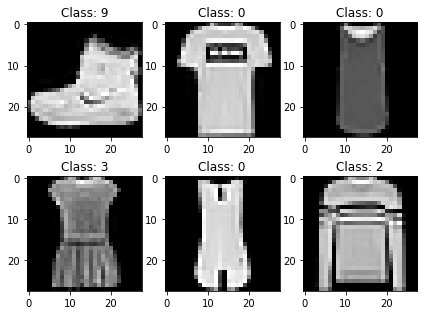

In [24]:
from matplotlib.figure import figaspect
##### FASHION-MNIST DATASET #####

# Acquire the data
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Plot the first 6 images with respective target class
plt.figure(figsize=(7,8))
for i in range(6):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
	plt.title('Class: {}'.format(y_train[i]))
plt.show()


The 10 target classes are: [('T-shirt/top', 0), ('Trouser', 1), ('Pullover', 2), ('Dress', 3), ('Coat', 4), ('Sandal', 5), ('Shirt', 6), ('Sneaker', 7), ('Bag', 8), ('Ankle Boot', 9)]


Traing:
Number of training images: 60000
Class frequency in training data: [('T-shirt/top', 6000), ('Trouser', 6000), ('Pullover', 6000), ('Dress', 6000), ('Coat', 6000), ('Sandal', 6000), ('Shirt', 6000), ('Sneaker', 6000), ('Bag', 6000), ('Ankle Boot', 6000)]


Testing:
Number of testing images: 10000
Class frequency in testing data: [('T-shirt/top', 1000), ('Trouser', 1000), ('Pullover', 1000), ('Dress', 1000), ('Coat', 1000), ('Sandal', 1000), ('Shirt', 1000), ('Sneaker', 1000), ('Bag', 1000), ('Ankle Boot', 1000)]


Training and testing split: 86%, 14%


Graphs:


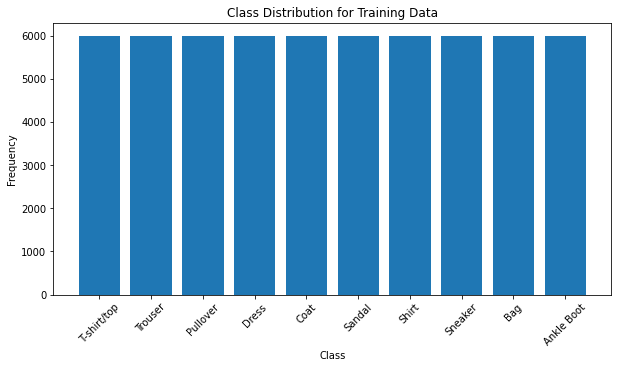

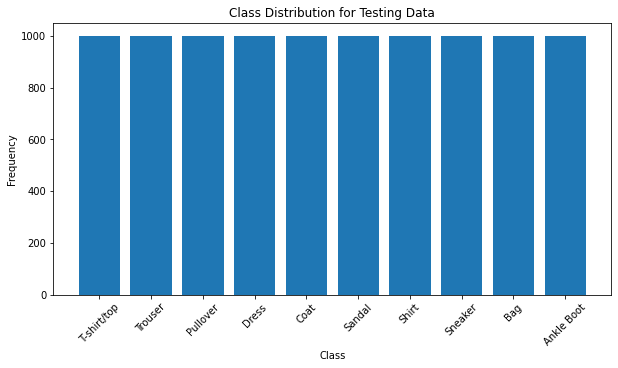

In [25]:
##### ANALYZE THE FASHION-MNIST DATASET #####

# Print class labels with respective 0-9 number they correspond to  
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
class_labels = list(set(y_train))
mapped = zip(class_names, set(class_labels))
print('The 10 target classes are:', list(mapped))

print('\n')

# Training Data
print('Traing:')
len_training = len(x_train)
print('Number of training images:', len_training)
classes, counts = np.unique(y_train, return_counts=True)
class_frequencies = list(zip(class_names, counts))
print('Class frequency in training data:', class_frequencies)

# Graphing the class frequency ditribution for training data
figure = plt.figure(figsize=(10, 5))
plt.bar(class_names,counts)
plt.xticks(rotation=45)
plt.title('Class Distribution for Training Data')
plt.xlabel('Class')
plt.ylabel('Frequency')

print('\n')

# Testing Data 
print('Testing:')
len_testing = len(x_test)
print('Number of testing images:', len_testing)
classes, counts = np.unique(y_test, return_counts=True)
class_frequencies = list(zip(class_names, counts))
print('Class frequency in testing data:', class_frequencies)

# Graphing the class frequency ditribution for testing data
figure = plt.figure(figsize=(10, 5))
plt.bar(class_names,counts)
plt.xticks(rotation=45)
plt.title('Class Distribution for Testing Data')
plt.xlabel('Class')
plt.ylabel('Frequency')

print('\n')

testing_probs = (len_testing / (len_testing + len_training)) * 100
training_probs = (len_training / (len_testing + len_training)) * 100
print('Training and testing split: ' + str(round(training_probs)) + '%, ' + str(round(testing_probs)) + '%')

print('\n')
print('Graphs:')

In [26]:
def load_data():# Normalize the data (we want values between 0 and 1)
  # Acquire the data
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0

  # Reshape data (transform 2d image into 1d vector)
  x_train, x_test = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[1])), x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[1]))

  ##### ONE-HOT ENCODE Y_TRAIN and Y_TEST #####

  # Categorically encode the labels (like one-hot encoding)
  y_train, y_test = to_categorical(y_train), to_categorical(y_test)
  return x_train, y_train, x_test, y_test

In [27]:
x_train, y_train, x_test, y_test = load_data()

## Task 2: Implement a Multilayer Perceptron

In this mini-project, you will implement a multilayer perceptron (MLP) to classify image data. An MLP is composed of three types of layers: (1) an input layer, (2) hidden layers, (3) an output layer (see Figure 1). You should implement it from scratch based on the code available in the slides. Your implementation should include the backpropagation and the mini-batch gradient descent algorithm used (e.g., SGD).

You are free to implement the MLP as you see fit, but you should follow the equations that are presented in the lecture slides, and you must implement it from scratch (i.e., you cannot use TensorFlow or PyTorch or any other library). Using the Numpy package is encouraged. Regarding the implementation, we recommend the following approach:
* Implement the MLP as a python class. The constructor for the class should take as input the activation function (e.g., ReLU), the number of hidden layers (e.g., 2) and the number of units in the hidden layers (e.g., [64, 64]) and it should initialize the weights and biases (with an initializer of your choice) as well as other important properties of the MLP.
* The class should have (at least) two functions:
    * A fit function, which takes the training data (i.e., X and y)—as well as other hyperparameters (e.g., the learning rate and number of gradient descent iterations)—as input. This function should train your model by modifying the model parameters.
    * A predict function, which takes a set of input points (i.e., X) as input and outputs predictions (i.e., yˆ) for these points.
* In addition to the model classes, you should also define a functions evaluate acc to evaluate the model accuracy. This function should take the true labels (i.e., y), and target labels (i.e., yˆ) as input, and it should output the accuracy score.

You are also free to use any Python libraries you like to tune the hyper-parameters; see for example https:// scikit-learn.org/stable/modules/grid_search.html.

In [28]:
def get_next_batch(N, batch_size, epochs):
  # N = x_train.shape[0]
  inds = np.random.permutation(N)
  for iter in range(epochs):
    # print(f"iter={iter}, i={iter * batch_size}, j={(iter+1) * batch_size}")
    batch_inds = inds[iter * batch_size: (iter+1) * batch_size]
    x, y = x_train[inds[batch_inds],:], y_train[inds[batch_inds],:]
    yield x, y


In [29]:
def l2_penalty(w):
  return np.sum((w**2))/2

### MLP

In [30]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    
    def __init__(self, hidden_nodes, hidden_layers, act_func=False, drop_out=False, rate=0.5): # dropout half of the units by default
        self.hidden_nodes = hidden_nodes
        self.hidden_layers = hidden_layers
        self.act_func = act_func
        self.drop_out = drop_out
        self.rate = rate

    def softmax(self, Z):
      # Z has shape N x C
      Z_exp = np.exp(Z)
      # print(Z_exp.shape)
      partition = Z_exp.sum(1, keepdims=True)
      output = Z_exp / partition
      # ouput has shape N
      return output

    def fit(self, x, y, epochs, batch_size, optimizer):
      N,D = x.shape
      def gradient_fn(x, y, params):
          N, D = x.shape
          n = len(params)
          dparams = []
          layers = []
          q_lst = [] # a parallel q list
          if self.hidden_layers == 0:
            layers.append(x) 
          else:
            q = np.dot(x, params[0].T) # N x M
            z = self.act_func.run(q) # N x M
            layers.append(x) # N x D
            q_lst.append(q) # N x M
            layers.append(z) # N x M
            for i in range(1, n-1):
              q = np.dot(layers[i], params[i])
              q_lst.append(q)
              z = self.act_func.run(q) # i = 1,...,n-2
              layers.append(z)

          u = np.dot(layers[n-1], params[n-1].T) # N x C, z = layers[n-2], w = params[n-1], u \in N x C
          yh = self.softmax(u) # N x C
          dy = yh - y #N x C
          dw = np.dot(dy.T, layers[n-1])/N #C x M
          dparams.append(dw)
          for i in range(self.hidden_layers):
            if dy.ndim == 1:
              dz = np.outer(dy, params[n-i-1]) #N x M, -1 for indexing starting at 0
            else:
              dz = np.dot(dy, params[n-i-1]) #N x M
            q = q_lst[n-i-2]
            dv = np.dot((dz * self.act_func.run(layers[n-i-1], q=q, deriv=True)).T, layers[n-i-2])/N #M x D
            dparams.insert(0, dv)
            dy = dz
          return dparams

      # initialize weights
      if self.hidden_layers == 0:
        params0 = [np.random.randn(y.shape[1], x.shape[1]) * .01] # C x D
      else:
        params0 = []
        params0.append(np.random.randn(self.hidden_nodes, D) * .01) # V \in R^M x D
        for i in range(1, self.hidden_layers): 
          params0.append(np.random.randn(self.hidden_nodes, self.hidden_nodes) * .01) # M x M
        params0.append(np.random.randn(y.shape[1], self.hidden_nodes) * .01) # W \in R^C x M

      if self.drop_out:
        permuted_nodes = np.random.permutation(self.hidden_nodes) # randomly permute hidden nodes
        nodes_to_slice = self.rate * self.hidden_nodes
        dropped = permuted_nodes[int(nodes_to_slice):]
        self.hidden_nodes = dropped
      
      self.params = optimizer.run(gradient_fn, x, y, params0)
      
      return self
    
    def predict(self, x):
      if self.hidden_layers == 0:
        z = self.act_func.run(np.dot(x, self.params[0].T))
      else:
        z = self.act_func.run(np.dot(x, self.params[0].T))
        for i in range(1, len(self.params)-1):
          z = self.act_func.run(np.dot(z, self.params[i]))
        z = np.dot(z, self.params[len(self.params)-1].T)
      yh = self.softmax(z)
      return np.argmax(yh, 1) # softmax returns the probability matrix 

    # misclassification rate
    def evaluation(self, y_pred, y):
      return round(np.sum(y_pred == y.argmax(1)) / len(y), 2)


### Gradiant Descent

In [31]:
class GradientDescent:
    
    def __init__(self, epochs, batch_size, data_size, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.epochs = epochs
        self.batch_size = batch_size
        self.data_size = data_size
        
    def run(self, optimizer, x, y, params): # use data_size as batch size
      for epoch in range(epochs):
        norms = np.array([np.inf])
        t = 1
        print(f"Epoch={epoch}.")
        while np.any(norms > self.epsilon) and t < self.max_iters:
          grads = optimizer(x, y, params)
          # print(grads)
          for p in range(len(params)):
            params[p] -= self.learning_rate * grads[p]
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grads])
      return params

In [32]:
class StochasticGradientDescent(GradientDescent):
        
    def run(self, optimizer, x, y, params):
        batch_gen = get_next_batch(self.data_size, self.batch_size, self.epochs)
        for epoch in range(self.epochs):# get random mini batch
            x, y = next(batch_gen)
            print(f"Epoch={epoch}, Batch_size={x.shape[0]}.")
            norms = np.array([np.inf])
            t = 1
            while np.any(norms > self.epsilon) and t < self.max_iters:
                grads = optimizer(x, y, params) # calculate gradients of the sampled batch
                # print(grads)
                for p in range(len(params)):
                  # mean_grad ?
                  params[p] -= self.learning_rate * grads[p] # update weights based on the sampled batch
                t += 1
                norms = np.array([np.linalg.norm(g) for g in grads])
        return params

### Activation function

In [33]:
class ActivationFunctions:

  def __init__(self, fun="ReLU", upsilon=0.01):
    self.fun = fun
    self.upsilon = upsilon

  def run(self, Z, q=None, deriv=False):
    if self.fun == "ReLU" and deriv:
      output = q > 0
      output = output.astype(np.int8)

    elif self.fun == "ReLU" and deriv == False:
      output = np.maximum(0, Z)

    elif self.fun == "leaky_ReLU" and deriv: 
      a1 = np.full_like(q, 1.0)
      a2 = np.full_like(q, self.upsilon)
      output = np.where((q >= 0), a1, a2)

    elif self.fun == "leaky_ReLU" and deriv == False:
      output = np.maximum(0, Z) + self.upsilon * np.minimum(0, Z)

    elif self.fun == "Softplus" and deriv:
      output = 1 / (1 + np.exp(-Z))

    elif self.fun == "Softplus" and deriv == False:
      output = np.log(1 + np.exp(Z))

    elif self.fun == "identity" and deriv:
      output = 1

    elif self.fun == "identity" and deriv == False:
      output = Z

    elif self.fun == "sigmoid" and deriv:
      output = Z * (1 - Z)

    elif self.fun == "sigmoid" and deriv == False:
      output = 1 / (1 + np.exp(-Z))
    
    elif self.fun == "tanh" and deriv:
      output = 1 - np.square(np.tanh(q))

    elif self.fun == "tanh" and deriv == False:
       output = (np.exp(Z) - np.exp(-Z))/ (np.exp(Z) + np.exp(-Z))

    else:
      print(f'No such activation function. ')
      return None

    return output

In [34]:
epochs = 5
batch_size=2000
data_size, input_nodes = x_train.shape

hidden_nodes = 128
output_nodes = np.max(y_train)+1
max_iters = 100
lr = .01
optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)
act_func = ActivationFunctions('ReLU')

mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func)
mlp_pred = mlp.fit(x_train, y_train, epochs, batch_size, optimizer).predict(x_test) 

filename = 'fitted_model.sav'
pickle.dump(mlp, open(filename, 'wb'))


Epoch=0, Batch_size=2000.
Epoch=1, Batch_size=2000.
Epoch=2, Batch_size=2000.
Epoch=3, Batch_size=2000.
Epoch=4, Batch_size=2000.


In [35]:
fitted_model = pickle.load(open(filename, 'rb'))
yh = fitted_model.predict(x_test) 
mlp_acc = mlp.evaluation(mlp_pred, y_test)
print(mlp_acc)

0.72


## Task 3: Run the experiments and report

The goal of the experiments in this part is to have you explore the consequences of important decisions made while training neural networks. Split the dataset into training and test sets. Use test set to estimate performance in all of the experiments after training the model with training set. Evaluate the performance using accuracy. You are welcome to perform any experiments and analyses you see fit (e.g., the effect of data augmentation / L1-L2 regularization / number of hidden layers / . . . on accuracy), but at a minimum you must complete the following experiments in the order stated below:
1. First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having 128 units and ReLU activations, (3) an MLP with 2 hidden layers each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test accuracy of these three models on the Fashion-MNIST dataset. Comment on how non-linearity and network depth affects the accuracy. Are the results that you obtain expected?
2. Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with model having ReLU activations. Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?
3. Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, add dropout regularization to the network and train the MLP in this way. How does this affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements.
4. Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?
5. Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully connected layers to be 128. Also, set the activations in all of the layers to be ReLU. Train this CNN on the Fashion-MNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide comments on your results.
6. Using your MLP implementation, try to come up with an MLP architecture that performs as good as possible. How does this MLP perform compared to the CNN in part 5? Justify your choice of network architecture parameters through careful experiments.
7. You can report your findings either in the form of a table or a plot in the write-up. However, include in your colab notebooks the plots of the test and train performance of the MLPs/CNN as a function of training epochs. This will allow you to see how much the network should be trained before it starts to overfit to the training data.

Note 1: The above experiments are the minimum requirements that you must complete; however, this project is open-ended.

For example, you might investigate the effect of the width (number of units in the hidden layers) of the MLP on its test accuracy or the effect of the CNN’s convolutinal layer hyperparameters (number of filters, kernel size, stride, padding, . . . ) on its test accuracy. It is also possible to examine the effect of different dropout node proportions on the final performance. Another interesting thing to report might be training the MLP and CNN with 10k , k ∈ {0, 1, 2, 3, 4} images and plotting the test accuracy. You do not need to do all of these things or tune every parameter, but you should demonstrate creativity, rigour, and an understanding of the course material in how you run your chosen experiments and how you report on them in your write-up.

Note 2: We expect you to provide plots/tables in your report that justifies your choice of hyperparameters (the learning rates of the MLPs/CNNs in parts 1-6, the architectural parameters of the MLPs/CNNs in parts 5 & 6). You are not required to perform cross-validation in this project.

#### 3.1 MLP with no hidden layer v.s. MLP with one hidden layer v.s. MLP with 2 hidden layers 

Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy score: Zero-layer-MLP:0.68,  One-layer-MLP: 0.68,  Two-layer-MLP: 0.71.


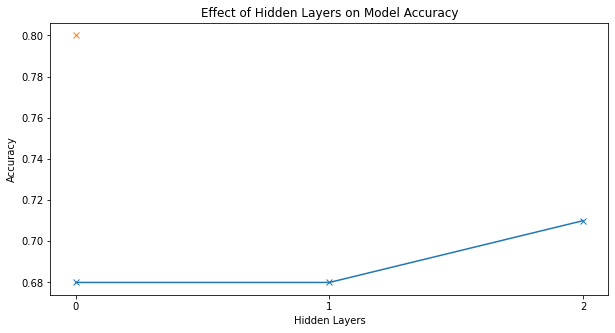

In [39]:
#############HYPER PARAMETERS########
epochs=5
batch_size=100
data_size, input_nodes = x_train.shape

hidden_nodes = 128
output_nodes = np.max(y_train)+1
max_iters = 100
lr = .01

#############TESTING HIDDEN LAYERS ########

hidden_layers = [0, 1, 2]
accuracy_zero = [] 
accuracy_one = [] 
accuracy_two = []

optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=0.01, max_iters=max_iters)
act_func = ActivationFunctions('ReLU')

zero_mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func)
zero_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
zero_mlp_acc = mlp.evaluation(y_pred=zero_mlp_pred,y=y_test)
accuracy_zero.append(zero_mlp_acc)


one_mlp = MLP(hidden_nodes, hidden_layers=1, act_func=act_func)
one_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
one_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
accuracy_one.append(one_mlp_acc)

two_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=act_func)
two_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
two_mlp_acc = mlp.evaluation(y_pred=two_mlp_pred,y=y_test)
accuracy_two.append(two_mlp_acc)

print("Accuracy score: " + str(f"Zero-layer-MLP:{zero_mlp_acc},  One-layer-MLP: {one_mlp_acc},  Two-layer-MLP: {two_mlp_acc}."))

data = {'Zero-layer':accuracy_zero[0], 'One-layer':accuracy_one[0], 'Two_layer':accuracy_two[0]}
layers = list(data.keys())
acc = list(data.values())
  
fig = plt.figure(figsize = (10, 5))

X_axis = np.arange(len(hidden_layers))

plt.plot(X_axis, acc, 0.8, marker='x')
plt.xticks(X_axis, hidden_layers)
 
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.title('Effect of Hidden Layers on Model Accuracy')
plt.show()

Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Learning rate of 0.1: Zero-layer-MLP:0.73,  One-layer-MLP: 0.72,  Two-layer-MLP: 0.75.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Learning rate of 0.01: Zero-layer-MLP:0.7,  One-layer-MLP: 0.69,  Two-layer-MLP: 0.68.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
E

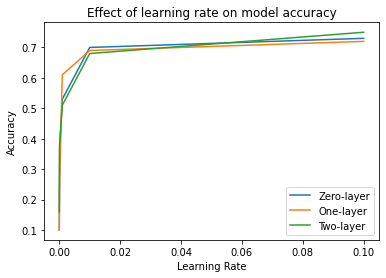

Epoch=0, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=0, Batch_size=100.
Epochs size 1: Zero-layer-MLP:0.55,  One-layer-MLP: 0.51,  Two-layer-MLP: 0.58.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epochs size 5: Zero-layer-MLP:0.68,  One-layer-MLP: 0.72,  Two-layer-MLP: 0.7.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=5, Batch_size=100.
Epoch=6, Batch_size=100.
Epoch=7, Batch_size=100.
Epoch=8, Batch_size=100.
Epoch=9, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=5, Batch_s

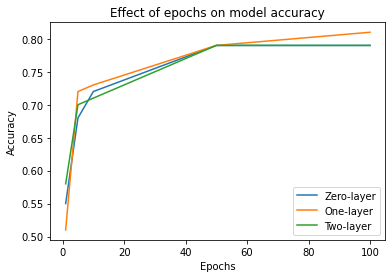

Epoch=0, Batch_size=0.
Epoch=1, Batch_size=0.
Epoch=2, Batch_size=0.
Epoch=3, Batch_size=0.
Epoch=4, Batch_size=0.
Epoch=0, Batch_size=0.
Epoch=1, Batch_size=0.
Epoch=2, Batch_size=0.
Epoch=3, Batch_size=0.
Epoch=4, Batch_size=0.
Epoch=0, Batch_size=0.
Epoch=1, Batch_size=0.
Epoch=2, Batch_size=0.
Epoch=3, Batch_size=0.
Epoch=4, Batch_size=0.
Batch size of 0: Zero-layer-MLP:0.1,  One-layer-MLP: 0.1,  Two-layer-MLP: 0.1.
Epoch=0, Batch_size=10.
Epoch=1, Batch_size=10.
Epoch=2, Batch_size=10.
Epoch=3, Batch_size=10.
Epoch=4, Batch_size=10.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


Epoch=0, Batch_size=10.
Epoch=1, Batch_size=10.
Epoch=2, Batch_size=10.
Epoch=3, Batch_size=10.
Epoch=4, Batch_size=10.
Epoch=0, Batch_size=10.
Epoch=1, Batch_size=10.
Epoch=2, Batch_size=10.
Epoch=3, Batch_size=10.
Epoch=4, Batch_size=10.
Batch size of 10: Zero-layer-MLP:0.54,  One-layer-MLP: 0.44,  Two-layer-MLP: 0.4.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Batch size of 100: Zero-layer-MLP:0.65,  One-layer-MLP: 0.7,  Two-layer-MLP: 0.69.
Epoch=0, Batch_size=1000.
Epoch=1, Batch_size=1000.
Epoch=2, Batch_size=1000.
Epoch=3, Batch_size=1000.
Epoch=4, Batch_size=1000.
Epoch=0, Batch_size=1000.
Epoch=1, Batch_size=1000.
Epoch=2, Batch_size=1000.
Epoch=3, Bat

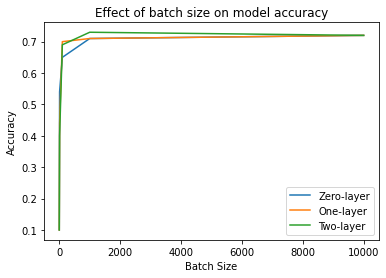

In [40]:
#### CHANGING LEARNING RATE ####
lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]
accuracy_zero = [] 
accuracy_one = [] 
accuracy_two = []

for i in range(len(lr_list)):
  optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr_list[i], max_iters=max_iters)
  act_func = ActivationFunctions('ReLU')

  zero_mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func)
  zero_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  zero_mlp_acc = mlp.evaluation(y_pred=zero_mlp_pred,y=y_test)
  accuracy_zero.append(zero_mlp_acc)


  one_mlp = MLP(hidden_nodes, hidden_layers=1, act_func=act_func)
  one_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  one_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
  accuracy_one.append(one_mlp_acc)

  two_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=act_func)
  two_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  two_mlp_acc = mlp.evaluation(y_pred=two_mlp_pred,y=y_test)
  accuracy_two.append(two_mlp_acc)

  print("Learning rate of " + str(lr_list[i]) + ": " + str(f"Zero-layer-MLP:{zero_mlp_acc},  One-layer-MLP: {one_mlp_acc},  Two-layer-MLP: {two_mlp_acc}."))

plt.plot(lr_list, accuracy_zero, label = "Zero-layer")
plt.plot(lr_list, accuracy_one, label = "One-layer")
plt.plot(lr_list, accuracy_two, label = "Two-layer")
plt.title('Effect of learning rate on model accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### CHANGING NUMBER OF EPOCHS ####
epochs_list = [1, 5, 10, 50, 100]
accuracy_zero = [] 
accuracy_one = [] 
accuracy_two = []

for i in range(len(epochs_list)):
  optimizer = StochasticGradientDescent(epochs=epochs_list[i], batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)
  act_func = ActivationFunctions('ReLU')

  zero_mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func)
  zero_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs_list[i], batch_size=batch_size, optimizer=optimizer).predict(x_test)
  zero_mlp_acc = mlp.evaluation(y_pred=zero_mlp_pred,y=y_test)
  accuracy_zero.append(zero_mlp_acc)


  one_mlp = MLP(hidden_nodes, hidden_layers=1, act_func=act_func)
  one_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs_list[i], batch_size=batch_size, optimizer=optimizer).predict(x_test)
  one_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
  accuracy_one.append(one_mlp_acc)

  two_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=act_func)
  two_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs_list[i], batch_size=batch_size, optimizer=optimizer).predict(x_test)
  two_mlp_acc = mlp.evaluation(y_pred=two_mlp_pred,y=y_test)
  accuracy_two.append(two_mlp_acc)

  print("Epochs size " + str(epochs_list[i]) + ": " + str(f"Zero-layer-MLP:{zero_mlp_acc},  One-layer-MLP: {one_mlp_acc},  Two-layer-MLP: {two_mlp_acc}."))

plt.plot(epochs_list, accuracy_zero, label = "Zero-layer")
plt.plot(epochs_list, accuracy_one, label = "One-layer")
plt.plot(epochs_list, accuracy_two, label = "Two-layer")
plt.title('Effect of epochs on model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### CHANGING BATCH SIZE ####
batch_size_list = [0, 10, 100, 1000, 10000]
accuracy_zero = [] 
accuracy_one = [] 
accuracy_two = [] 

for i in range(len(batch_size_list)):
  optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size_list[i], data_size=data_size, learning_rate=lr, max_iters=max_iters)
  act_func = ActivationFunctions('ReLU')

  zero_mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func)
  zero_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size_list[i], optimizer=optimizer).predict(x_test)
  zero_mlp_acc = mlp.evaluation(y_pred=zero_mlp_pred,y=y_test)
  accuracy_zero.append(zero_mlp_acc)

  one_mlp = MLP(hidden_nodes, hidden_layers=1, act_func=act_func)
  one_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size_list[i], optimizer=optimizer).predict(x_test)
  one_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
  accuracy_one.append(one_mlp_acc)

  two_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=act_func)
  two_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size_list[i], optimizer=optimizer).predict(x_test)
  two_mlp_acc = mlp.evaluation(y_pred=two_mlp_pred,y=y_test)
  accuracy_two.append(two_mlp_acc)

  print("Batch size of " + str(batch_size_list[i]) + ": " + str(f"Zero-layer-MLP:{zero_mlp_acc},  One-layer-MLP: {one_mlp_acc},  Two-layer-MLP: {two_mlp_acc}."))

plt.plot(batch_size_list, accuracy_zero, label = "Zero-layer")
plt.plot(batch_size_list, accuracy_one, label = "One-layer")
plt.plot(batch_size_list, accuracy_two, label = "Two-layer")
plt.title('Effect of batch size on model accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### 3.2 Replace the activation function of the 2-layer-MLP with tanh and Leaky-ReLU

In [41]:
optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)

Two_layer_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=ActivationFunctions(fun='tanh'))
two_layer_mlp_pred = Two_layer_mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
two_layer_mlp_acc = Two_layer_mlp.evaluation(y_pred = two_layer_mlp_pred, y=y_test)

print("Accuracy using tanh:", two_layer_mlp_acc)

Two_layer_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=ActivationFunctions(fun='leaky_ReLU'))
two_layer_mlp_pred = Two_layer_mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
two_layer_mlp_acc = Two_layer_mlp.evaluation(y_pred = two_layer_mlp_pred, y=y_test)

print("Accuracy using leaky_ReLU:", two_layer_mlp_acc)

Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy using tanh: 0.18
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy using leaky_ReLU: 0.12


#### 3.3 Dropout regulation
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, add dropout regularization to the network and train the MLP in this way. 

Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy with dropout rate of 0.1: Zero-layer-MLP:0.72,  One-layer-MLP: 0.72,  Two-layer-MLP: 0.11.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy with dropout rate of 0.25: Zero-layer-MLP:0.72,  One-layer-MLP: 0.72,  Two-layer-MLP: 0.13.
Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.

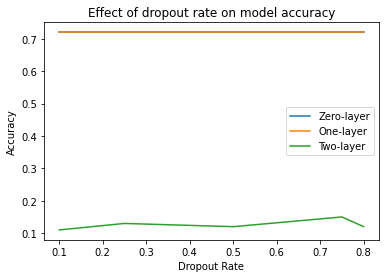

In [43]:
# randomly drop out nodes by a probablitity
drop_rate = [0.10, 0.25, 0.50, 0.75, 0.80]
accuracy_zero = [] 
accuracy_one = [] 
accuracy_two = []

for i in range(len(drop_rate)):
  act_func = ActivationFunctions(fun = 'ReLU')
  optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)

  Zero_layer_mlp = MLP(hidden_nodes, hidden_layers=0, act_func=act_func, drop_out=True, rate=drop_rate[i])
  zero_layer_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  zero_layer_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
  accuracy_zero.append(zero_layer_mlp_acc)
  
  One_layer_mlp = MLP(hidden_nodes, hidden_layers=1, act_func=act_func, drop_out=True, rate=drop_rate[i])
  one_layer_mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  one_layer_mlp_acc = mlp.evaluation(y_pred=one_mlp_pred,y=y_test)
  accuracy_one.append(one_layer_mlp_acc)

  Two_layer_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=act_func, drop_out=True, rate=drop_rate[i])
  two_layer_mlp_pred = Two_layer_mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
  two_layer_mlp_acc = Two_layer_mlp.evaluation(y_pred = two_layer_mlp_pred, y=y_test)
  accuracy_two.append(two_layer_mlp_acc)

  print("Accuracy with dropout rate of " + str(drop_rate[i]) + ": " + str(f"Zero-layer-MLP:{zero_layer_mlp_acc},  One-layer-MLP: {one_layer_mlp_acc},  Two-layer-MLP: {two_layer_mlp_acc}."))

plt.plot(drop_rate, accuracy_zero, label = "Zero-layer")
plt.plot(drop_rate, accuracy_one, label = "One-layer")
plt.plot(drop_rate, accuracy_two, label = "Two-layer")
plt.title('Effect of dropout rate on model accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3.4 Train with unnormalized images
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?

In [44]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

In [45]:
np.min(x_train*255.0), np.max(x_train*255.0)

(0.0, 255.0)

In [46]:
optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)

Two_layer_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=ActivationFunctions(fun='ReLU'))
two_layer_mlp_pred = Two_layer_mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer)

print(Two_layer_mlp.params)

Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
[array([[-0.00651663,  0.00839541,  0.00887048, ..., -0.00361465,
         0.0254467 , -0.00874345],
       [ 0.00859798, -0.00635761,  0.00120648, ...,  0.00937568,
        -0.00305576,  0.00440792],
       [-0.00175454, -0.01208737,  0.0061786 , ..., -0.00545217,
        -0.0024135 , -0.01910855],
       ...,
       [ 0.00537708,  0.00668956,  0.00035599, ..., -0.00568083,
        -0.00751626, -0.00658634],
       [ 0.01533227, -0.00654814, -0.01003084, ...,  0.00080144,
         0.00168831, -0.00626007],
       [-0.02612132,  0.00692763,  0.02296498, ...,  0.00503181,
        -0.00492035, -0.00487883]]), array([[-8.81630702e-03, -8.21345949e-03,  1.08660018e-03, ...,
         9.94733640e-03,  2.15240068e-03, -1.98779455e-03],
       [-1.60618193e-02, -1.01749977e-02, -7.07887916e-03, ...,
         1.54770660e-03, -6.82027259e-03, -1.25949098e-03],
       [-5.3

In [47]:
x_train, x_test = x_train * 255.0, x_test * 255.0 # undo normalization
optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batch_size, data_size=data_size, learning_rate=lr, max_iters=max_iters)

Two_layer_mlp = MLP(hidden_nodes, hidden_layers=2, act_func=ActivationFunctions(fun='ReLU'))
two_layer_mlp_pred = Two_layer_mlp.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, optimizer=optimizer).predict(x_test)
two_layer_mlp_acc = Two_layer_mlp.evaluation(y_pred = two_layer_mlp_pred, y=y_test)

print("Accuracy using unomalized images:", two_layer_mlp_acc)


Epoch=0, Batch_size=100.
Epoch=1, Batch_size=100.
Epoch=2, Batch_size=100.
Epoch=3, Batch_size=100.
Epoch=4, Batch_size=100.
Accuracy using unomalized images: 0.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


#### 3.5 CNN with 2 convolutional and 2 fully connected layers. 
Set the activations in all of the layers to be ReLu. 
Train this CNN on the Fashion-MNIST dataset. 

In [48]:
!pip install -q -U tensorflow>=1.8.0
import tensorflow as tf

In [49]:
def build_CNNmodel(filters=[64,32,256], pool_size=2, kernel_size=2, padding='same', activation='relu', dropout=[0.3, 0.3, 0.5], show_summary=False):
  model = tf.keras.Sequential()
  # Must define the input shape in the first layer of the neural network
  model.add(tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size, padding=padding, activation=activation, input_shape=(28,28,1))) 
  model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
  model.add(tf.keras.layers.Dropout(dropout[0]))
  model.add(tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size, padding=padding, activation=activation))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
  model.add(tf.keras.layers.Dropout(dropout[1]))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation=activation))
  model.add(tf.keras.layers.Dense(128, activation=activation))
  model.add(tf.keras.layers.Dropout(dropout[2]))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # Take a look at the model summary
  if show_summary:
    model.summary()

  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  return model

In [50]:
def load_CNNdata():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  # Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
  (x_train, x_valid) = x_train[5000:], x_train[:5000] 
  (y_train, y_valid) = y_train[5000:], y_train[:5000]

  # Reshape input data from (28, 28) to (28, 28, 1)
  w, h = 28, 28
  x_train = x_train.reshape(x_train.shape[0], w, h, 1)
  x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
  x_test = x_test.reshape(x_test.shape[0], w, h, 1)

  # One-hot encode the labels
  y_train = tf.keras.utils.to_categorical(y_train, 10)
  y_valid = tf.keras.utils.to_categorical(y_valid, 10)
  y_test = tf.keras.utils.to_categorical(y_test, 10)
  return x_train, y_train, x_valid, y_valid, x_test, y_test


In [51]:
CNNmodel = build_CNNmodel(show_summary=True)
x_train, y_train, x_valid, y_valid, x_test, y_test = load_CNNdata()

CNNmodel.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid))

# Evaluate the model on test set
score = CNNmodel.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

#### 3.6 Optimal MLP
Using your MLP implementation, try to come up with an MLP architecture that performs as well as possible. How does this MLP perform compared to the CNN in part 5? Justify your choice of network architecture parameters through careful experiments.

In [52]:
epochs = 100
lr = 0.1
batchsize=600
dropout_rate = 0.5
optimizer = StochasticGradientDescent(epochs=epochs, batch_size=batchsize, data_size=data_size, learning_rate=lr, max_iters=max_iters)

In [53]:
x_train, y_train, x_test, y_test = load_data()
# one layer mlp
mlp = MLP(
    hidden_nodes=128, 
    hidden_layers=1, 
    act_func=ActivationFunctions('sigmoid'), 
    drop_out=True, 
    rate=dropout_rate)
mlp_pred = mlp.fit(x_train, y_train, epochs=epochs, batch_size=batchsize, optimizer=optimizer).predict(x_test)
mlp_acc = mlp.evaluation(y_pred=mlp_pred, y=y_test)


Epoch=0, Batch_size=600.
Epoch=1, Batch_size=600.
Epoch=2, Batch_size=600.
Epoch=3, Batch_size=600.
Epoch=4, Batch_size=600.
Epoch=5, Batch_size=600.
Epoch=6, Batch_size=600.
Epoch=7, Batch_size=600.
Epoch=8, Batch_size=600.
Epoch=9, Batch_size=600.
Epoch=10, Batch_size=600.
Epoch=11, Batch_size=600.
Epoch=12, Batch_size=600.
Epoch=13, Batch_size=600.
Epoch=14, Batch_size=600.
Epoch=15, Batch_size=600.
Epoch=16, Batch_size=600.
Epoch=17, Batch_size=600.
Epoch=18, Batch_size=600.
Epoch=19, Batch_size=600.
Epoch=20, Batch_size=600.
Epoch=21, Batch_size=600.
Epoch=22, Batch_size=600.
Epoch=23, Batch_size=600.
Epoch=24, Batch_size=600.
Epoch=25, Batch_size=600.
Epoch=26, Batch_size=600.
Epoch=27, Batch_size=600.
Epoch=28, Batch_size=600.
Epoch=29, Batch_size=600.
Epoch=30, Batch_size=600.
Epoch=31, Batch_size=600.
Epoch=32, Batch_size=600.
Epoch=33, Batch_size=600.
Epoch=34, Batch_size=600.
Epoch=35, Batch_size=600.
Epoch=36, Batch_size=600.
Epoch=37, Batch_size=600.
Epoch=38, Batch_size=6

In [ ]:
print("Optimal MLP: ", mlp_acc)

Optimal MLP:  0.85


#### 3.7 Experiment: Testing the effect of kernel size on the performance of CNNmodel on image classification

k=2
k=4
k=6
k=8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


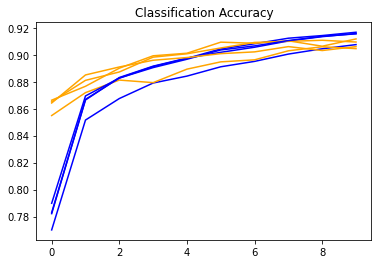

Accuracy: mean=90.790 std=0.282, n=4


In [ ]:
kernel_sizes = np.arange(2,10,2)

histories = []
accuracies = []

for k in range(2,10,2): # don't use kernel sizes
  print(f"k={k}")
  CNNmodel = build_CNNmodel(kernel_size=k)
  x_train, y_train, x_valid, y_valid, x_test, y_test = load_CNNdata()
  history = CNNmodel.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=0)
  _, accuracy = CNNmodel.evaluate(x_test,  y_test, verbose=0) 
  histories.append(history)
  accuracies.append(accuracy)

def summarize_results(histories):
	for i in range(len(histories)):
		# # plot loss
		# plt.subplot(211)
		# plt.title('Cross Entropy Loss')
		# plt.plot(histories[i].history['loss'], color='blue', label='train')
		# plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(111)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()
 
summarize_results(histories)
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(accuracies)*100, np.std(accuracies)*100, len(accuracies)))
	